In [1]:
import ssms
import torch
import pickle
import numpy as np
import os
import sys
import lanfactory
from copy import deepcopy
import pandas as pd
from os import PathLike
from typing import Callable, Tuple
import pytensor 
pytensor.config.floatX = "float32"
import pytensor.tensor as pt
import jax.numpy as jnp
from pytensor.graph import Apply, Op
from pytensor.link.jax.dispatch import jax_funcify
from jax import grad, jit, vmap
from numpy.typing import ArrayLike
from jax.scipy.special import expit


LogLikeFunc = Callable[..., ArrayLike]
LogLikeGrad = Callable[..., ArrayLike]

import pymc as pm
from pytensor.tensor.random.op import RandomVariable

import warnings 
warnings.filterwarnings('ignore')

class NetworkLike:
    @classmethod
    def make_logp_jax_funcs(
        cls,
        params_is_reg: list[bool],
        list_params: list,
        model = None,
        n_params: int | None = None,
        bounds = None,
        kind: str = 'lan',
    ) -> Tuple[LogLikeFunc, LogLikeGrad, LogLikeFunc,]:
        """Makes a jax log likelihood function from flax network forward pass.
        Args:
            model: A path or url to the ONNX model, or an ONNX Model object
            already loaded.
            compile: Whether to use jit in jax to compile the model.
        Returns: A triple of jax or Python functions. The first calculates the
            forward pass, the second calculates the gradient, and the third is
            the forward-pass that's not jitted.
        """
        if kind == 'lan':
            def logp_lan(data: np.ndarray, *dist_params) -> ArrayLike:
                """
                Computes the sum of the log-likelihoods given data and arbitrary
                numbers of parameters assuming the trial by trial likelihoods
                are derived from a LAN.
                Args:
                    data: response time with sign indicating direction.
                    dist_params: a list of parameters used in the likelihood computation.
                Returns:
                    The sum of log-likelihoods.
                """
                
                
                transformed_params = []
                for i in range(len(dist_params)):
                    if list_params[i] in bounds.keys():
                        transformed_params.append(expit(dist_params[i]) * (bounds[list_params[i]][1] - bounds[list_params[i]][0]) + bounds[list_params[i]][0])
                    else:
                        transformed_params.append(dist_params[i])
                input_matrix = jnp.concatenate((jnp.array(transformed_params[:-1]), data))

                ll = jnp.multiply(jnp.exp(model(input_matrix)),1-transformed_params[-1]) + transformed_params[-1] * 1/10

                # Network forward and sum
                return jnp.sum(
                    jnp.squeeze(jnp.log(ll))
                )
            # The vectorization of the logp function
            vmap_logp_lan = vmap(
                logp_lan,
                in_axes=[0] + [0 if is_regression else None for is_regression in params_is_reg],
            )
            # logp_grad_lan = grad(logp_lan, argnums=range(1, 1 + n_params))
            # return jit(logp_lan), jit(logp_grad_lan), logp_lan
            
            def vjp_vmap_logp_lan(
                data: np.ndarray, *dist_params: list[float | ArrayLike], gz: ArrayLike
            ) -> list[ArrayLike]:
                """Compute the VJP of the log-likelihood function.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation.
                gz
                    The value of vmap_logp at which the VJP is evaluated, typically is just
                    vmap_logp(data, *dist_params)

                Returns
                -------
                list[ArrayLike]
                    The VJP of the log-likelihood function computed at gz.
                """
                _, vjp_fn = vjp(vmap_logp_lan, data, *dist_params)
                return vjp_fn(gz)[1:]

            return jit(vmap_logp_lan), jit(vjp_vmap_logp_lan), vmap_logp_lan

        elif kind == 'cpn':
            def logp_cpn(data: np.ndarray, *dist_params) -> ArrayLike:
                """
                Computes the sum of the log-likelihoods given data and arbitrary
                numbers of parameters assuming the trial-by-trial likelihood derive for a CPN.
                Args:
                    data: response time with sign indicating direction.
                    dist_params: a list of parameters used in the likelihood computation.
                Returns:
                    The sum of log-likelihoods.
                """

                # Makes a matrix to feed to the LAN model
                # n_nogo_go_condition = jnp.sum(data > 0)
                # n_nogo_nogo_condition = jnp.sum(data < 0)
                # n_omission = jnp.sum(data>0)
                # n_total = jnp.sum(data>=0)
                transformed_params = []

                for i in range(len(dist_params)):
                    if list_params[i] in bounds.keys():
                        transformed_params.append(expit(dist_params[i]) * (bounds[list_params[i]][1] - bounds[list_params[i]][0]) + bounds[list_params[i]][0])
                    else:
                        transformed_params.append(dist_params[i])
                        
                params_matrix  = jnp.array(transformed_params)

                # AF-TODO Bugfix here !
                # dist_params_nogo = jnp.stack(dist_params).reshape(1, -1)
                # dist_params_nogo = dist_params_nogo.at[0].set((-1) * dist_params_nogo[0])

                net_out = jnp.squeeze(model(params_matrix))

                # Include lapse distribution (uniform) into omission likelihood
                # dist_params[-1]: outlier
                # dist_params[-2]: deadline (in second)

                out = jnp.sum(jnp.multiply(jnp.log(jnp.exp(net_out) + 1e-64),data))

                return out
            vmap_logp_cpn = vmap(
                logp_cpn,
                in_axes=[0] + [0 if is_regression else None for is_regression in params_is_reg],
            )
            def vjp_vmap_logp_cpn(
                data: np.ndarray, *dist_params: list[float | ArrayLike], gz: ArrayLike
            ) -> list[ArrayLike]:
                """Compute the VJP of the log-likelihood function.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation.
                gz
                    The value of vmap_logp at which the VJP is evaluated, typically is just
                    vmap_logp(data, *dist_params)

                Returns
                -------
                list[ArrayLike]
                    The VJP of the log-likelihood function computed at gz.
                """
                _, vjp_fn = vjp(vmap_logp_cpn, data, *dist_params)
                return vjp_fn(gz)[1:]

            return jit(vmap_logp_cpn), jit(vjp_vmap_logp_cpn), vmap_logp_cpn

    @staticmethod

    def make_jax_logp_ops(
        logp: LogLikeFunc,
        logp_vjp: LogLikeGrad,
        logp_nojit: LogLikeFunc,
    ) -> Op:
        """Wrap the JAX functions and its gradient in pytensor Ops.

        Parameters
        ----------
        logp
            A JAX function that represents the feed-forward operation of the LAN
            network.
        logp_vjp
            The Jax function that calculates the VJP of the logp function.
        logp_nojit
            The non-jit version of logp.

        Returns
        -------
        Op
            An pytensor op that wraps the feed-forward operation and can be used with
            pytensor.grad.
        """

        class LANLogpOp(Op):  # pylint: disable=W0223
            """Wraps a JAX function in an pytensor Op."""

            def make_node(self, data, *dist_params):
                """Take the inputs to the Op and puts them in a list.

                Also specifies the output types in a list, then feed them to the Apply node.

                Parameters
                ----------
                data
                    A two-column numpy array with response time and response.
                dist_params
                    A list of parameters used in the likelihood computation. The parameters
                    can be both scalars and arrays.
                """
                inputs = [
                    pt.as_tensor_variable(data),
                ] + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]

                outputs = [pt.vector()]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, output_storage):
                """Perform the Apply node.

                Parameters
                ----------
                inputs
                    This is a list of data from which the values stored in
                    output_storage are to be computed using non-symbolic language.
                output_storage
                    This is a list of storage cells where the output
                    is to be stored. A storage cell is a one-element list. It is
                    forbidden to change the length of the list(s) contained in
                    output_storage. There is one storage cell for each output of
                    the Op.
                """
                result = logp(*inputs)
                output_storage[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

            def grad(self, inputs, output_gradients):
                """Perform the pytensor.grad() operation.

                Parameters
                ----------
                inputs
                    The same as the inputs produced in `make_node`.
                output_gradients
                    Holds the results of the perform `perform` method.

                Notes
                -----
                    It should output the VJP of the Op. In other words, if this `Op`
                    outputs `y`, and the gradient at `y` is grad(x), the required output
                    is y*grad(x).
                """
                results = lan_logp_vjp_op(inputs[0], *inputs[1:], gz=output_gradients[0])
                output = [
                    pytensor.gradient.grad_not_implemented(self, 0, inputs[0]),
                ] + results

                return output

        class LANLogpVJPOp(Op):  # pylint: disable=W0223
            """Wraps the VJP operation of a jax function in an pytensor op."""

            def make_node(self, data, *dist_params, gz):
                """Take the inputs to the Op and puts them in a list.

                Also specifies the output types in a list, then feed them to the Apply node.

                Parameters
                ----------
                data:
                    A two-column numpy array with response time and response.
                dist_params:
                    A list of parameters used in the likelihood computation.
                """
                inputs = (
                    [
                        pt.as_tensor_variable(data),
                    ]
                    + [pt.as_tensor_variable(dist_param) for dist_param in dist_params]
                    + [pt.as_tensor_variable(gz)]
                )
                outputs = [inp.type() for inp in inputs[1:-1]]

                return Apply(self, inputs, outputs)

            def perform(self, node, inputs, outputs):
                """Perform the Apply node.

                Parameters
                ----------
                inputs
                    This is a list of data from which the values stored in
                    `output_storage` are to be computed using non-symbolic language.
                output_storage
                    This is a list of storage cells where the output
                    is to be stored. A storage cell is a one-element list. It is
                    forbidden to change the length of the list(s) contained in
                    output_storage. There is one storage cell for each output of
                    the Op.
                """
                results = logp_vjp(inputs[0], *inputs[1:-1], gz=inputs[-1])

                for i, result in enumerate(results):
                    outputs[i][0] = np.asarray(result, dtype=node.outputs[i].dtype)

        lan_logp_op = LANLogpOp()
        lan_logp_vjp_op = LANLogpVJPOp()

        # Unwraps the JAX function for sampling with JAX backend.
        @jax_funcify.register(LANLogpOp)
        def logp_op_dispatch(op, **kwargs):  # pylint: disable=W0612,W0613
            return logp_nojit

        return lan_logp_op


# Loaded Net

passing 1
wandb not available
wandb not available


In [2]:
model_config = ssms.config.model_config['weibull']
try:
    jax_infer_lan = lanfactory.trainers.MLPJaxFactory(
        network_config="../network/weibull/lan/2b8c70363dff11ef8680a0423f3e9b42_lan_weibull_network_config.pickle",
        train=False,
    )

    forward_pass_lan, forward_pass_jitted_lan = jax_infer_lan.make_forward_partial(
        seed=42,
        input_dim=model_config["n_params"] + 2,
        state="../network/weibull/lan/2b8c70363dff11ef8680a0423f3e9b42_lan_weibull__train_state.jax",
        add_jitted=True,
    )

    # Loaded Net
    jax_infer_cpn = lanfactory.trainers.MLPJaxFactory(
        network_config="../network/weibull/cpn/cd5cafb23ec111efa0bca0423f3e9b5e_opn_weibull_deadline_network_config.pickle",
        train=False,
    )

    forward_pass_cpn, forward_pass_jitted_cpn = jax_infer_cpn.make_forward_partial(
        seed=42,
        input_dim=model_config["n_params"] + 1,
        state="../network/weibull/cpn/cd5cafb23ec111efa0bca0423f3e9b5e_cpn_weibull_deadline__train_state.jax",
        add_jitted=True,
    )
except:
    jax_infer_lan = lanfactory.trainers.MLPJaxFactory(
        network_config="../network/weibull/lan/2b8c70363dff11ef8680a0423f3e9b42_lan_weibull_network_config.pickle",
        train=False,
    )

    forward_pass_lan, forward_pass_jitted_lan = jax_infer_lan.make_forward_partial(
        seed=42,
        input_dim=model_config["n_params"] + 2,
        state="../network/weibull/lan/2b8c70363dff11ef8680a0423f3e9b42_lan_weibull__train_state.jax",
        add_jitted=True,
    )

    # Loaded Net
    jax_infer_cpn = lanfactory.trainers.MLPJaxFactory(
        network_config="../network/weibull/cpn/cd5cafb23ec111efa0bca0423f3e9b5e_opn_weibull_deadline_network_config.pickle",
        train=False,
    )

    forward_pass_cpn, forward_pass_jitted_cpn = jax_infer_cpn.make_forward_partial(
        seed=42,
        input_dim=model_config["n_params"] + 1,
        state="../network/weibull/cpn/cd5cafb23ec111efa0bca0423f3e9b5e_cpn_weibull_deadline__train_state.jax",
        add_jitted=True,
    )

passing through identity
passing through transform


In [3]:
# Instantiate LAN logp functions
lan_logp_jitted, lan_logp_vjp_jitted, lan_logp = NetworkLike.make_logp_jax_funcs(model = forward_pass_lan,
                                                                                  n_params = 7,
                                                                                  kind = "lan",
                                                                                  list_params = ['v','a','z','t','alpha','beta','p_outlier'],
                                                                                  bounds = {'v':(-3,3),
                                                                                            'a':(0.2,2.5),
                                                                                            'z':(0.1,0.9),
                                                                                            't':(0.01,0.5),
                                                                                            'alpha':(0.5,4.5),
                                                                                            'beta':(0.5,4.5),
                                                                                            'p_outlier':(0,0.05)},
                                                                                  params_is_reg=[False]*7)

# Turn into logp op
lan_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = lan_logp_jitted,
                                logp_vjp = lan_logp_vjp_jitted,
                                logp_nojit = lan_logp)

# Instantiate CPN logp functions
cpn_logp_jitted, cpn_logp_vjp_jitted, cpn_logp = NetworkLike.make_logp_jax_funcs(model = forward_pass_cpn,
                                                                                 n_params = 7,
                                                                                 list_params = ['v','a','z','t','alpha','beta','deadline'],
                                                                                 bounds = {'v':(-3,3),
                                                                                           'a':(0.2,2.5),
                                                                                           'z':(0.1,0.9),
                                                                                           't':(0.01,0.5),
                                                                                           'alpha':(0.5,4.5),
                                                                                           'beta':(0.5,4.5)},
                                                                                 kind = "cpn",
                                                                                 params_is_reg=[False]*7)

# Turn into logp op
cpn_logp_op = NetworkLike.make_jax_logp_ops(
                                logp = cpn_logp_jitted,
                                logp_vjp = cpn_logp_vjp_jitted,
                                logp_nojit = cpn_logp)

In [5]:
from pymc.sampling import jax as pmj

# Just to keep the blog-post pretty automatically
import warnings 
warnings.filterwarnings('ignore')

jobid = 61
a_list  = np.linspace(1,2,5)
alpha_list  = np.linspace(1,4,5)
beta_list = np.linspace(1,4,5)
a_index = jobid//25
sub_id = jobid%25
alpha_index = sub_id%5
beta_index = sub_id//5
# a_list = [1.5]
# theta_list = [0.95]
# Test parameters:
# v, z, t, deadline = 2, 0.5, 0.3, 1.25

a_true = []
alpha_true = []
beta_true = []

a_pred_nd = []
alpha_pred_nd = []
beta_pred_nd = []
v_pred_nd = []

a_pred_d = []
alpha_pred_d = []
beta_pred_d = []
v_pred_d = []

omission_list = []

for i in range(1):
    v, a, z, t, alpha, beta, deadline = 1.3, a_list[a_index], 0.5, 0.3, alpha_list[alpha_index], beta_list[beta_index],1.25
    a_true.append(a)
    alpha_true.append(alpha)
    beta_true.append(beta)

    # Comparison simulator run
    sim_out = ssms.basic_simulators.simulator.simulator(
        model='weibull', theta=[v, a, z, t, alpha,beta], n_samples=1000
    )
    data = np.hstack([sim_out['rts'], sim_out['choices']]).astype(np.float32)
    data_commission = data[data[:,0]<deadline,:]
    data_omission = data[:,0]>=deadline
    data_omission = data_omission.astype(np.float32)
    omission_rate = np.mean(data_omission)
    print(i)
    print(omission_rate)

    omission_list.append(omission_rate)
    
    with pm.Model() as ddm:
        # Define simple Uniform priors
        v1 = pm.Normal("v", mu=0, sigma=1)
        a1 = pm.Normal("a", mu=0, sigma=1)
        z = pt.constant(0.5)
        t = pm.Normal("t", mu=0, sigma=1)
        alpha =pm.Normal("alpha", mu=0, sigma=1)
        beta = pm.Normal("beta", mu=0, sigma=1)
        p_outlier=pm.Normal('p_outlier',mu=0,sigma=1)
        deadline = pt.constant(1.25)
        # t = pm.Uniform("t", 0.0, 2.0)
        # theta = pm.Uniform("theta",0,1.3)
        # ddl = pt.constant(1.25)
        
    
        pm.Potential("choice_rt", lan_logp_op(data_commission, v1, a1, z, t, alpha,beta, p_outlier))
        #pm.Potential("omission", cpn_logp_op(data_omission, v1, a1, z, t, theta,deadline))
    
        ddm_blog_traces_numpyro_nd = pmj.sample_numpyro_nuts(
                chains=2, draws=1000, tune=4000,target_accept=0.99,progressbar=False,
            initvals={'v':0,'a':0,'t':0,'alpha':0,'beta':0,'p_outlier':0})
        post_summary = pm.summary(ddm_blog_traces_numpyro_nd)
    v_pred_nd.append(1/(1+np.exp(-post_summary.loc['v','mean'])) * 6 - 3)
    a_pred_nd.append(1/(1+np.exp(-post_summary.loc['a','mean'])) * 2.3 + 0.2)
    alpha_pred_nd.append(1/(1+np.exp(-post_summary.loc['alpha','mean'])) * 4 + 0.5)
    beta_pred_nd.append(1/(1+np.exp(-post_summary.loc['beta','mean'])) * 4 + 0.5)
    
    
    
    with pm.Model() as ddm:
        # Define simple Uniform priors
        v1 = pm.Normal("v", mu=0, sigma=1)
        a1 = pm.Normal("a", mu=0, sigma=1)
        z = pt.constant(0.5)
        t = pm.Normal("t", mu=0, sigma=1)
        alpha =pm.Normal("alpha", mu=0, sigma=1)
        beta = pm.Normal("beta", mu=0, sigma=1)
        p_outlier=pm.Normal('p_outlier',mu=0,sigma=1)
        deadline = pt.constant(1.25)
        # t = pm.Uniform("t", 0.0, 2.0)
        # theta = pm.Uniform("theta",0,1.3)
        # ddl = pt.constant(1.25)
        
    
        pm.Potential("choice_rt", lan_logp_op(data_commission, v1, a1, z, t, alpha,beta,p_outlier))
        pm.Potential("omission", cpn_logp_op(data_omission, v1, a1, z, t, alpha,beta,deadline))
    
        ddm_blog_traces_numpyro_d = pmj.sample_numpyro_nuts(
                chains=2, draws=1000, tune=4000,target_accept=0.99,progressbar=False,
            initvals={'v':0,'a':0,'t':0,'alpha':0,'beta':0,'p_outlier':0}
                )
        post_summary = pm.summary(ddm_blog_traces_numpyro_d)
    v_pred_d.append(1/(1+np.exp(-post_summary.loc['v','mean'])) * 6 - 3)
    a_pred_d.append(1/(1+np.exp(-post_summary.loc['a','mean'])) * 2.3 + 0.2)
    alpha_pred_d.append(1/(1+np.exp(-post_summary.loc['alpha','mean'])) * 4 + 0.5)
    beta_pred_d.append(1/(1+np.exp(-post_summary.loc['beta','mean'])) * 4 + 0.5)
    
percentile_list = pd.DataFrame(
    {'a_true': a_true,
     'alpha_true': alpha_true,
     'beta_true': beta_true,
     'a_pred_nd': a_pred_nd,
     'v_pred_nd': v_pred_nd,
     'alpha_pred_nd': alpha_pred_nd,
     'beta_pred_nd': beta_pred_nd,
     'a_pred_d': a_pred_d,
     'v_pred_d': v_pred_d,
     'alpha_pred_d': alpha_pred_d,
     'beta_pred_d': beta_pred_d,
     'omission_rate': omission_list
    })

percentile_list.to_csv('results/output10_'+sys.argv[1]+'.csv',index=False)

0
0.376
passing through identity
passing through identity
passing through identity
passing through identity


We recommend running at least 4 chains for robust computation of convergence diagnostics


passing through transform
passing through transform
passing through identity
passing through transform
passing through identity
passing through transform
passing through identity


We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


OSError: Cannot save file into a non-existent directory: 'results'

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'p_outlier'}>,
        <Axes: title={'center': 'p_outlier'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

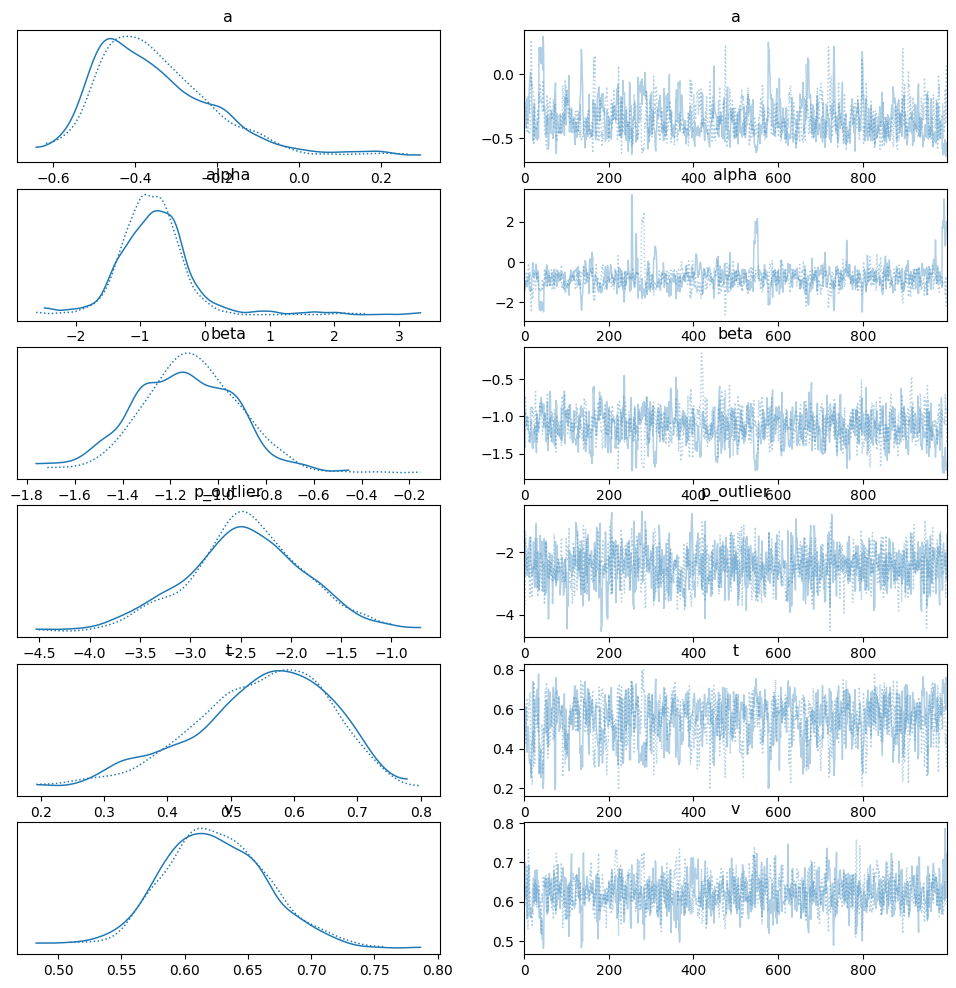

In [168]:
pm.plot_trace(ddm_blog_traces_numpyro_d)

In [157]:
logit(post_summary.loc['a','mean'])

nan

In [158]:
post_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.365,0.228,-0.633,0.114,0.028,0.020,95.0,248.0,1.02
alpha,-1.334,0.555,-2.564,-0.513,0.060,0.044,120.0,259.0,1.02
beta,-0.956,0.172,-1.271,-0.625,0.007,0.005,660.0,679.0,1.00
p_outlier,-2.056,0.603,-3.234,-0.983,0.019,0.014,1015.0,980.0,1.00
t,0.670,0.164,0.370,0.916,0.018,0.013,97.0,220.0,1.02
v,0.572,0.054,0.452,0.656,0.006,0.004,122.0,299.0,1.01


In [159]:
from scipy.special import logit

In [163]:
percentile_list

,a_true,alpha_true,beta_true,a_pred_nd,alpha_pred_nd,beta_pred_nd,a_pred_d,alpha_pred_d,beta_pred_d,omission_rate
0,1.1,1.3,2.5,1.069425,3.326460,0.806249,1.197381,1.484787,1.550786,0.157
1,1.1,1.3,2.5,0.982668,2.998288,0.805966,1.028723,1.527710,2.069824,0.162
2,1.1,1.3,2.5,1.006067,3.323140,0.789169,1.115293,1.493722,1.716273,0.175
3,1.1,1.3,2.5,1.120257,2.916804,0.795674,1.352300,1.038346,1.816628,0.199
4,1.1,1.3,2.5,0.991989,4.080802,0.801755,1.161394,1.960675,1.609115,0.176
5,1.1,1.3,2.5,1.059174,2.989837,0.817754,1.223440,1.187157,1.935730,0.172
6,1.1,1.3,2.5,2.147425,2.030898,1.288729,1.224576,1.266181,1.717966,0.172
7,1.1,1.3,2.5,2.130691,1.835243,1.305965,1.091705,1.647181,1.596336,0.149
8,1.1,1.3,2.5,1.073213,2.886094,0.803994,1.147992,1.421638,1.643911,0.148
9,1.1,1.3,2.5,1.059712,3.654729,0.801476,1.151895,1.749534,1.475169,0.155


In [15]:
t = np.linspace(0,2,201)

In [16]:
1/(1+np.exp(-post_summary.loc['t','mean'])) * 0.49 + 0.01

0.35705263816464966

In [29]:
beta_true = 0.8

alpha_true = 4

bound = np.exp(-np.power(t/beta_true, alpha_true))

In [30]:
bound

array([1.00000000e+00, 9.99999976e-01, 9.99999609e-01, 9.99998022e-01,
       9.99993750e-01, 9.99984741e-01, 9.99968360e-01, 9.99941384e-01,
       9.99900005e-01, 9.99839832e-01, 9.99755889e-01, 9.99642618e-01,
       9.99493878e-01, 9.99302953e-01, 9.99062549e-01, 9.98764802e-01,
       9.98401279e-01, 9.97962991e-01, 9.97440391e-01, 9.96823391e-01,
       9.96101369e-01, 9.95263183e-01, 9.94297183e-01, 9.93191230e-01,
       9.91932717e-01, 9.90508587e-01, 9.88905364e-01, 9.87109174e-01,
       9.85105783e-01, 9.82880628e-01, 9.80418860e-01, 9.77705382e-01,
       9.74724902e-01, 9.71461977e-01, 9.67901077e-01, 9.64026637e-01,
       9.59823131e-01, 9.55275132e-01, 9.50367392e-01, 9.45084920e-01,
       9.39413063e-01, 9.33337595e-01, 9.26844808e-01, 9.19921608e-01,
       9.12555613e-01, 9.04735254e-01, 8.96449883e-01, 8.87689875e-01,
       8.78446739e-01, 8.68713227e-01, 8.58483438e-01, 8.47752931e-01,
       8.36518829e-01, 8.24779916e-01, 8.12536745e-01, 7.99791724e-01,
      

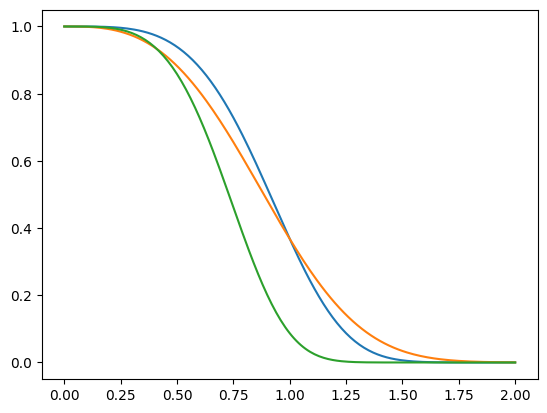

In [35]:
import matplotlib.pyplot as plt

beta_true = 1

alpha_true = 4

bound = np.exp(-np.power(t/beta_true, alpha_true))

plt.plot(t,bound)

beta_true = 1

alpha_true = 3

bound = np.exp(-np.power(t/beta_true, alpha_true))
plt.plot(t,bound)

beta_true = 0.8

alpha_true = 4

bound = np.exp(-np.power(t/beta_true, alpha_true))
plt.plot(t,bound)



In [131]:
parameter_matrix = np.zeros((3, 7))

parameter_vector = np.array([1.3, 1.1, 0.5, 0.3, 1.5, ])

deadline = 1.25

# vary the first parameter across rows (the 'v' parameter in our case')
parameter_matrix[:, 0] = np.linspace(-0.5, 0.5, 3)

# set the rest to the values used above
for i in range(0, 6, 1):
    parameter_matrix[:, i] = parameter_vector[i]
parameter_matrix[:,6] = deadline


parameter_matrix1 = np.zeros((3, 7))

parameter_vector1 = np.array([1.3, 1.1, 0.5, 0.3, 1.3, 2.5])

deadline = 1.25

# vary the first parameter across rows (the 'v' parameter in our case')
parameter_matrix[:, 0] = np.linspace(-0.5, 0.5, 3)

# set the rest to the values used above
for i in range(0, 6, 1):
    parameter_matrix[:, i] = parameter_vector[i]
parameter_matrix[:,6] = deadline

In [132]:
from ssms.basic_simulators import simulator

passing through identity
passing through transform
passing through transform
passing through identity
passing through transform
passing through transform
passing through identity
passing through transform
passing through transform


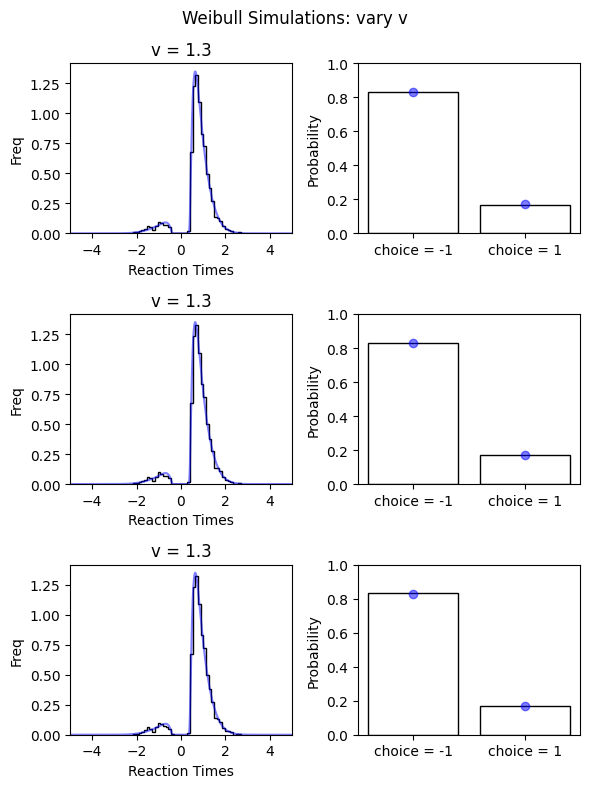

In [133]:
# Make Figure
fig, axs = plt.subplots(3,2, figsize = (6, 8))
fig.suptitle('Weibull Simulations: vary v')

n_trajectories = 2000
for i in range(3):
    simulation_data_tmp = simulator.simulator(model = 'weibull',
                                theta = parameter_matrix[i, :6],
                                n_samples = n_trajectories)

    # LAN
    inp_ = np.zeros((2000, 8))
    inp_[:, 0] = parameter_matrix[i, 0]  # v parameter --> varies
    inp_[:, 1] = parameter_matrix[i, 1], # a parameter
    inp_[:, 2] = parameter_matrix[i, 2], # z parameter
    inp_[:, 3] = parameter_matrix[i, 3], # ndt parameter
    inp_[:, 4] = parameter_matrix[i, 4],
    inp_[:, 5] = parameter_matrix[i, 5],
    inp_[:, 6] = np.concatenate([np.linspace(5, 0, 1000),
                                 np.linspace(0, 5, 1000)]) # rt
    inp_[:, 7] = np.concatenate([(-1)*np.ones(1000), np.ones(1000)]) # choices

    for j in range(2):
        if j == 0:
            # Reaction Times + Choices
            # Simulator
            axs[i, j].hist(np.squeeze(simulation_data_tmp['rts']) * np.squeeze(simulation_data_tmp['choices']),
                       histtype = 'step',
                       color = 'black',
                       bins = 40,
                       density = True,
                       )

            # LAN
            axs[i, j].plot(inp_[:, 6] * inp_[:, 7], jnp.exp(forward_pass_lan(inp_)), 
                           color = 'blue', alpha = 0.5)

            axs[i, j].set_title('v = ' + str(round(parameter_matrix[i, 0], 2)))
            axs[i, j].set_xlim(-5, 5)
            axs[i, j].set_xlabel('Reaction Times')
            axs[i, j].set_ylabel('Freq')


        else: 
            # Choice probabilities
            p_up = np.sum(simulation_data_tmp['rts'] > deadline) / n_trajectories
            choice_ps = [1 - p_up, p_up]

            # Simulator
            axs[i, j].bar(['choice = -1', 'choice = 1'], choice_ps, fill = None)

            # CPN
            axs[i, j].scatter(['choice = -1', 'choice = 1'], 
                              [(1 - jnp.exp(forward_pass_cpn(parameter_matrix[i, :]))), 
                               jnp.exp(forward_pass_cpn(parameter_matrix[i, :]))],
                              color = 'blue', alpha = 0.5)

            axs[i, j].set_ylabel('Probability')
            axs[i, j].set_ylim(0, 1)

fig.tight_layout()
plt.show()

In [100]:
np.mean(data_omission)

0.209

In [112]:
jnp.exp(forward_pass_cpn(parameter_matrix[i, :]))

passing through transform


Array([0.34811175], dtype=float32)